In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
# import warnings
# warnings.filterwarnings("ignore")

# Reading Data

In [2]:
df_chunk = pd.read_csv('train.csv', chunksize = 500000, low_memory = False)
chunks = []

In [3]:
coord_list = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
def remove_invalid(chunk):
    for c in coord_list:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
                    chunk = chunk.drop([i])
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
                    chunk = chunk.drop([i])
            elif(c == "fare_amount"):
                if(chunk[c][i] >= 200 or chunk[c][i] <= 0):
                    chunk = chunk.drop([i])
    return chunk
        

In [4]:
def remove_outlier(chunk, data_1):
    outliers_indices=[]
    threshold = 3
    mean_1 = np.mean(data_1)
    std_1 = np.std(data_1)
    
#     length = len(data_1)
    for i in chunk.index:
        z_score= (data_1[i] - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_indices.append(i)
    for i in outliers_indices:
        chunk = chunk.drop([i])
    return chunk


# print(len(detect_outlier(chunks[1]['fare_amount'])))

In [5]:
def split_datetime(chunk):
    hours = []
    mins = []
    secs = []
    years = []
    months = []
    days = []
    length = len(chunk['pickup_longitude'])
    
    for i in chunk.index:
        years.append(int(chunk['pickup_datetime'][i][0:4]))
        months.append(int(chunk['pickup_datetime'][i][5:7]) - 1) # 1 is subtracted to aid in days from jan 1st calculations
        days.append(int(chunk['pickup_datetime'][i][8:10]))
        hours.append(int(chunk['pickup_datetime'][i][11:13]))
        mins.append(int(chunk['pickup_datetime'][i][14:16]))
        secs.append(int(chunk['pickup_datetime'][i][17:19]))

    chunk['years'] = years
    chunk['months'] = months
    chunk['days'] = days
    chunk['hours'] = hours
    chunk['mins'] = mins
    chunk['secs'] = secs
    
    return chunk

In [6]:
def modify_datetime(chunk):
    chunk['secs_past_midnight'] = (chunk['hours']*3600) + (chunk['mins']*60) + (chunk['secs'])
    chunk['sin_spm'] = np.sin(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['cos_spm'] = np.cos(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['days_past_jan1'] = (chunk['months']*30) + (chunk['days'])
    chunk['sin_dpj'] = np.sin(2*np.pi*(chunk['days_past_jan1']/365))
    chunk['cos_dpj'] = np.cos(2*np.pi*(chunk['days_past_jan1']/365))
    
    return chunk

In [7]:
def split_data(chunk):
    y = chunk['fare_amount']
    X = pd.DataFrame(chunk)
    X = X.drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
    X = StandardScaler().fit_transform(X)
    return (X, y)

In [8]:
def linreg(X, y, linreg = LinearRegression()):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
#     linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return (linreg, rmse)

# X1_train, X1_test, y1_train, y1_test = train_test_split(features, target, random_state=1)

In [9]:
def save_model(model, filename): 
#     filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [10]:
def load_model(filename): 
    model = pickle.load(open(filename, 'rb'))
    return model

# Reading chunks and applying functions

In [32]:
count = 0
for chunk in df_chunk:
    if (count == 0):
        model = LinearRegression()
    else:
        model = load_model("model.sav")
        
    chunk = remove_invalid(chunk)
    chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk = remove_outlier(chunk, chunk['fare_amount'])
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    (X1, y1) = split_data(chunk)
    model, rmse = linreg(X1, y1, model)
    save_model(model, "model.sav")
    print(rmse)
    
    if (count == 0):
        chunks.append(pd.DataFrame(chunk))
    count += 1
    if(count == 4):
        break

3.3234072640090355
3.2852429007498265
3.307326681343063
3.3036649425245432


In [34]:
count = 0
test_chunk = pd.read_csv('test.csv', chunksize = 1000000, low_memory = False)
test_chunks = []
for chunk in test_chunk:
    test_chunks.append(pd.DataFrame(chunk))
    break
print(count)

0


In [36]:
test_chunks[0].head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04 UTC,-73.972484,40.742743,-73.918937,40.764496,1
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26 UTC,-73.985850,40.722826,-73.986301,40.739347,1
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42 UTC,-73.988917,40.740142,-73.982769,40.777291,1
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54 UTC,-73.977163,40.764490,-73.914474,40.771575,1
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59 UTC,-73.948849,40.778003,-73.977678,40.748692,2


In [35]:
test_chunks[0].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,-73.012053,40.222073,-73.031647,40.233667,1.692398
std,8.631907,4.699691,8.545333,4.651339,1.339879
min,-2089.709422,-0.049055,-2089.709422,-0.044617,0.000000
25%,-73.991715,40.736277,-73.991195,40.735407,1.000000
50%,-73.981607,40.753533,-73.980058,40.753885,1.000000
75%,-73.967765,40.767735,-73.964647,40.768652,2.000000
max,0.042612,651.140235,0.039857,651.136438,208.000000


# Visualization plots 

AxesSubplot(0.125,0.125;0.775x0.755)


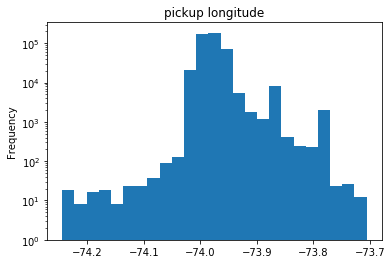

In [12]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_longitude"].plot.hist(ax = ax, title="pickup longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


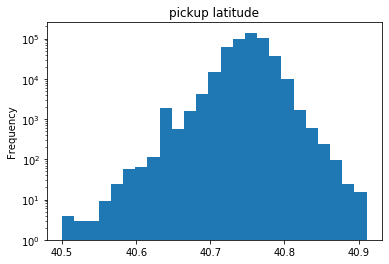

In [13]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_latitude"].plot.hist(ax = ax, title="pickup latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


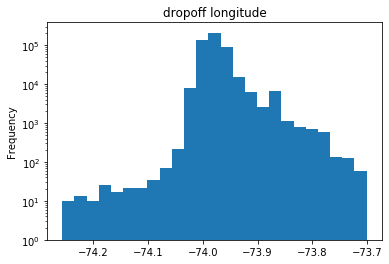

In [14]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_longitude"].plot.hist(ax = ax, title="dropoff longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


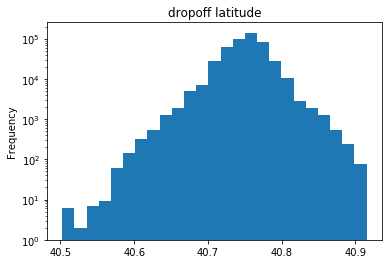

In [15]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_latitude"].plot.hist(ax = ax, title="dropoff latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


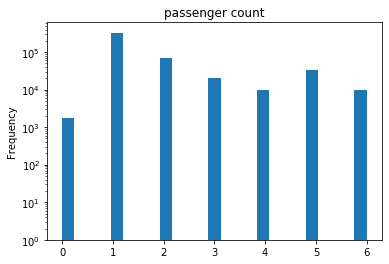

In [16]:
fig, ax = plt.subplots()
print(chunks[0]["passenger_count"].plot.hist(ax = ax, title="passenger count",bottom=1, bins=25))
ax.set_yscale('log')

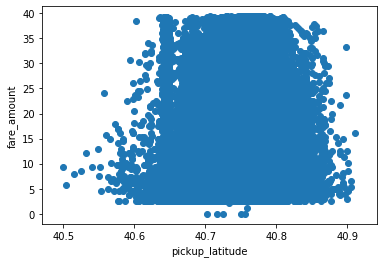

In [17]:
plt.scatter(chunks[0]["pickup_latitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_latitude")
plt.ylabel("fare_amount")
plt.show()

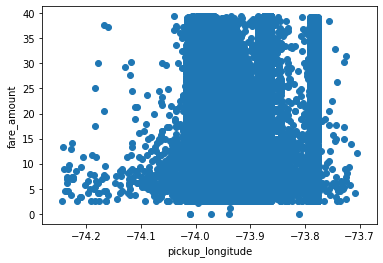

In [18]:
# fig, ax = plt.subplots()

plt.scatter(chunks[0]["pickup_longitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_longitude")
plt.ylabel("fare_amount")
plt.show()

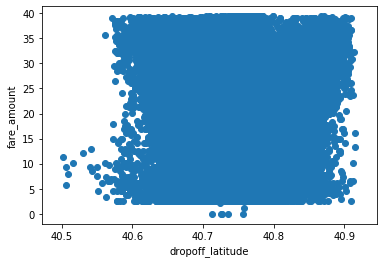

In [19]:
plt.scatter(chunks[0]["dropoff_latitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_latitude")
plt.ylabel("fare_amount")
plt.show()

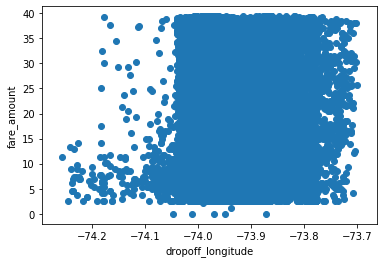

In [20]:
plt.scatter(chunks[0]["dropoff_longitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_longitude")
plt.ylabel("fare_amount")
plt.show()

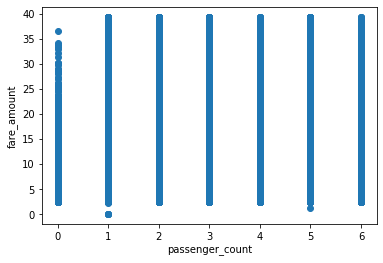

In [21]:
plt.scatter(chunks[0]["passenger_count"],chunks[0]["fare_amount"])
plt.xlabel("passenger_count")
plt.ylabel("fare_amount")
plt.show()

# Detecting Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa55f549cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa55f5499e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa55f549390>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa5507e12b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa5507e15f8>],
 'means': []}

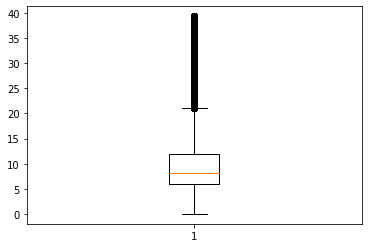

In [22]:
plt.boxplot(chunks[0].fare_amount)

In [23]:
chunks[0].to_csv('preprocessed.csv')
chunk1 = pd.read_csv('preprocessed.csv')
chunks.append(chunk1)
chunks[1].head()
chunks[0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,years,months,days,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
count,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000,475268.000000
mean,10.107973,-73.977948,40.752018,-73.975957,40.752164,1.681921,2011.720114,5.260314,15.711525,13.523380,29.604810,15.819801,50476.278195,-0.203902,-0.039651,173.520950,0.057311,-0.013111,0.038265
std,6.291704,0.027272,0.024555,0.028171,0.028644,1.305605,1.861543,3.437112,8.687479,6.526405,17.350608,19.420231,23517.566440,0.651542,0.729620,103.353719,0.714535,0.697127,0.034299
min,0.010000,-74.244171,40.500247,-74.256627,40.502482,0.000000,2009.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,-0.999991,-0.999963,0.000000
25%,6.000000,-73.992395,40.737345,-73.991623,40.736618,1.000000,2010.000000,2.000000,8.000000,9.000000,15.000000,0.000000,33913.000000,-0.816642,-0.773610,86.000000,-0.674444,-0.708627,0.016175
50%,8.100000,-73.982267,40.753675,-73.980761,40.754088,1.000000,2012.000000,5.000000,16.000000,14.000000,30.000000,4.000000,52800.000000,-0.337540,-0.097293,166.000000,0.154309,-0.012910,0.027426
75%,12.000000,-73.969265,40.767605,-73.966213,40.768455,2.000000,2013.000000,8.000000,23.000000,19.000000,45.000000,32.000000,70427.000000,0.362438,0.716403,264.000000,0.758306,0.677615,0.047947
max,39.330000,-73.705765,40.910962,-73.700763,40.915505,6.000000,2015.000000,11.000000,31.000000,23.000000,59.000000,59.000000,86399.000000,1.000000,1.000000,361.000000,0.999991,0.999852,0.437879


In [24]:
# indices = detect_outlier(chunks[1]['fare_amount'])
# for i in indices:
#     chunks[1] = chunks[1].drop([i])
#     print(i)

In [25]:
chunks[1].to_csv('preprocessed1.csv')
chunks.append(pd.read_csv('preprocessed1.csv'))

# Restricting coordinates to NYC

All coordinates outside NYC are directly dropped

# Removing all rows with null values

In [26]:
# type(chunks[0])
# print(chunks[0].isnull().sum())
# chunks[0].dropna(inplace = True)
# print(chunks[0].isnull().sum())
# chunks[0]['pickup_datetime'][0]
# chunks[0].describe()
# type(chunks[0]['dropoff_longitude'][161652])

# Splitting pickup date time 

# Generating secs after midnight and days past jan 1st

In [27]:
# chunks[0] = chunks[0].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
chunks[1].head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,years,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,0,2014-09-27 15:26:00.00000043,7.5,2014-09-27 15:26:00 UTC,-73.978463,40.759072,-73.963577,40.774255,1,2014,...,15,26,0,55560,-0.782608,-0.622515,267,-0.993257,-0.115935,0.030069
1,1,2012-05-07 07:57:00.000000142,6.5,2012-05-07 07:57:00 UTC,-73.982397,40.770245,-73.972450,40.764062,1,2012,...,7,57,0,28620,0.872496,-0.488621,127,0.816538,-0.577292,0.016130
2,2,2009-05-05 20:02:36.0000005,12.9,2009-05-05 20:02:36 UTC,-74.006507,40.718808,-73.961096,40.760711,1,2009,...,20,2,36,72156,-0.860297,0.509792,125,0.835925,-0.548843,0.087314
3,3,2010-07-15 22:57:00.00000042,20.1,2010-07-15 22:57:00 UTC,-73.999242,40.734165,-73.972597,40.751228,2,2010,...,22,57,0,82620,-0.271440,0.962455,195,-0.213521,-0.976938,0.043708
4,4,2010-08-31 13:15:00.00000028,4.1,2010-08-31 13:15:00 UTC,-73.977750,40.746274,-73.972760,40.755768,1,2010,...,13,15,0,47700,-0.321439,-0.946930,241,-0.845249,-0.534373,0.014484


In [28]:
# chunks[0]['manhattan_dist'] = abs(chunks[0]['pickup_latitude']-chunks[0]['dropoff_latitude']) + abs(chunks[0]['pickup_longitude']-chunks[0]['dropoff_longitude'])

In [29]:
chunks[0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,years,months,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,2014-09-27 15:26:00.00000043,7.5,2014-09-27 15:26:00 UTC,-73.978463,40.759072,-73.963577,40.774255,1,2014,8,...,15,26,0,55560,-0.782608,-0.622515,267,-0.993257,-0.115935,0.030069
1,2012-05-07 07:57:00.000000142,6.5,2012-05-07 07:57:00 UTC,-73.982397,40.770245,-73.972450,40.764062,1,2012,4,...,7,57,0,28620,0.872496,-0.488621,127,0.816538,-0.577292,0.016130
2,2009-05-05 20:02:36.0000005,12.9,2009-05-05 20:02:36 UTC,-74.006507,40.718808,-73.961096,40.760711,1,2009,4,...,20,2,36,72156,-0.860297,0.509792,125,0.835925,-0.548843,0.087314
3,2010-07-15 22:57:00.00000042,20.1,2010-07-15 22:57:00 UTC,-73.999242,40.734165,-73.972597,40.751228,2,2010,6,...,22,57,0,82620,-0.271440,0.962455,195,-0.213521,-0.976938,0.043708
4,2010-08-31 13:15:00.00000028,4.1,2010-08-31 13:15:00 UTC,-73.977750,40.746274,-73.972760,40.755768,1,2010,7,...,13,15,0,47700,-0.321439,-0.946930,241,-0.845249,-0.534373,0.014484


In [30]:
# features = chunks[0].drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
# target = chunks[0]['fare_amount']
# features = StandardScaler().fit_transform(features)

# pca = PCA(n_components=6)
# principalComponents = pca.fit_transform(features)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['PrincipalC1', 'PrincipalC2', 'PrincipalC3','PrincipalC4', 'PrincipalC5', 'PrincipalC6'])
# finalDf = pd.concat([principalDf, target], axis=1)
# finalDf.head()
# chunks[0].head()

# Generating X and y

# Test train split & Linear Regression & RMSE

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# print(X1_train.shape)
# print(y1_train.shape)
# print(X1_test.shape)
# print(y1_test.shape)

NameError: name 'X_train' is not defined

# Applying Linear Regression

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
# linreg1 = LinearRegression()
# linreg1.fit(X1_train, y1_train)

## Predicting outputs

In [ ]:
y_pred = linreg.predict(X_test)
# y1_pred = linreg1.predict(X1_test)

## Generating RMSE

In [ ]:
print("Without PCA: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("With PCA: ", np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))